In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def theoretical_results(lmbda, mu, k):
  rho = lmbda / mu
  p_k = rho**(k) * ( (1 - rho) / (1 - rho**(k+1)) )
  lmbda_a = lmbda * (1 - p_k)
  E_N = ( rho * (1 - rho**(k+1)) - rho**(k+1) * (k + 1) * (1 - rho) ) \
        / ( (1 - rho) * (1 - rho**(k+1)) )
  E_T = (1 / lmbda_a) * E_N
  E_W = E_T - (1 / mu)
  E_Nq = lmbda_a * E_W

  return E_N, E_Nq, E_T, E_W, p_k

def theoretical_PMF(lmbda, mu, k):
  rho = lmbda / mu
  p_0 = (1 - rho) / (1 - rho**(k+1))
  i = np.linspace(0, k, k + 1)
  return p_0 * rho**i

In [4]:
def main_loop(num_customers, AT, ST, k):
  buffer_leaves = np.zeros(k - 1) #keep the times at which customers leave the buffer (if they are queued)
  actual_AT = [AT[0]]
  DT = [AT[0] + ST[0]]
  WT = [0]
  blocked_customers = 0

  for i in range(1, num_customers):
    if AT[i] >= DT[-1]:
      DT.append(AT[i] + ST[i])
      actual_AT.append(AT[i])
      WT.append(0)
    else:
      if AT[i] >= min(buffer_leaves):
        WT.append(DT[-1] - AT[i])
        index_min = np.where(buffer_leaves == min(buffer_leaves))[0][0]
        buffer_leaves[index_min] = DT[-1]
        # print(buffer_leaves)
        DT.append(DT[-1] + ST[i])
        actual_AT.append(AT[i])
      else:
        blocked_customers += 1

  actual_AT = np.array(actual_AT)
  DT = np.array(DT)
  WT = np.array(WT)
  TT = DT - actual_AT
  block_prob = blocked_customers / num_customers

  return actual_AT, DT, TT, WT, block_prob

In [5]:
def track_customers(AT, DT, max_N, return_PMF=True):
  N = 0 #number of customers
  i, j = 0, 0 # i points to an arrival event and j to a depratrure event
  area_N, area_Nq = 0, 0 #area under curver of the N and Nq(number of customers in buffer)
  PMF = np.zeros(max_N + 1)
  clock, prev_event_time = 0, 0# clock points to the time of the current event
  last_arrival = max(AT)
  while( clock < last_arrival):
    clock = min(AT[i], DT[j])
    time_interval = clock - prev_event_time

    if clock == AT[i]: # arrival occurs before departure
      area_N += time_interval * N
      area_Nq += time_interval * max(N-1, 0)
      PMF[N] += time_interval
      prev_event_time = clock
      N += 1
      i += 1

    else: # departure occurs before arrival
      area_N += time_interval * N
      area_Nq += time_interval * max(N-1, 0)
      PMF[N] += time_interval
      prev_event_time = clock
      N -= 1
      j += 1

  #process the left departure events
  for j in range(j, len(DT)):
    clock = DT[j]
    time_interval = clock - prev_event_time
    area_N += time_interval * N
    area_Nq += time_interval * max(N-1, 0)
    PMF[N] += time_interval
    prev_event_time = clock
    N -= 1

  E_N = area_N / clock
  E_Nq = area_Nq / clock
  PMF = PMF / clock
  if return_PMF:
    return E_N, E_Nq, PMF
  return E_N, E_Nq

In [9]:
def simulation_results(num_customers, k, lmbda, mu):
  IAT = np.random.exponential(1/lmbda, num_customers)
  AT = np.cumsum(IAT)
  ST = np.random.exponential(1/mu, num_customers)
  actual_AT, DT, TT, WT, block_prob = main_loop(num_customers, AT, ST, k)
  E_T = np.mean(TT)
  E_W = np.mean(WT)
  E_N, E_Nq = track_customers(actual_AT, DT, max_N=k, return_PMF=False)
  return E_N, E_Nq, E_T, E_W, block_prob

In [6]:
def plot_PMF(sim_PMF, theo_PMF, semilog=False):
  max_PMF = max(theo_PMF)
  n_customer = np.arange(0.0, len(sim_PMF), 1.0)

  figure = plt.figure(figsize=(10,4), tight_layout=True, dpi=100)
  ax1 = figure.add_subplot(1, 2, 1)
  ax1.set_xlabel("n customer")
  ax1.set_ylabel("PMF")
  ax1.set_ylim([0, max_PMF + 0.25 * max_PMF])
  ax1.bar(n_customer, sim_PMF, width=1, align="center",
         edgecolor="black", linewidth=0.5, label="Simulation")
  ax1.plot(n_customer, theo_PMF, color="red", linestyle="--",
          marker="o", markerfacecolor="None", label="Theoretical")
  plt.legend()
  plt.grid(color="black", alpha=0.3, linewidth=0.5)

  ax2 = figure.add_subplot(1, 2, 2)
  ax2.set_xlabel("n customer")
  ax2.set_ylabel("PMF")
  if semilog:
    ax2.semilogy(n_customer, sim_PMF, "-b", label="Simulation")
    ax2.semilogy(n_customer, theo_PMF, color="red",linestyle="None",
                  marker="o", markerfacecolor="None", label="Theoretical")
  else:
    ax2.plot(n_customer, theo_PMF, "-b", label="Theoretical")
    ax2.plot(n_customer, sim_PMF, color="red",linestyle="None",
                  marker="o", markerfacecolor="None", label="Simulation")
  plt.legend()
  plt.grid(color="black", alpha=0.3, linewidth=0.5)
  plt.show()

In [7]:
def plot_PDF(input, theo_E, num_bins=50):
  min_val, max_val = min(input), max(input)
  bin_width = (max_val - min_val) / num_bins
  bins_center = np.linspace(min_val + bin_width/2, max_val - bin_width/2,
                            num_bins)
  freq, bins_edge = np.histogram(input, bins=num_bins)
  sim_PDF = freq / sum(freq) / bin_width
  theo_PDF = (1/theo_E) * np.exp(-(1/theo_E) * bins_center)
  #----plot----
  figure = plt.figure(figsize=(10, 4), tight_layout=True, dpi=100)
  ax1 = figure.add_subplot(1, 2, 1)
  ax1.set_xlabel("t (time)")
  ax1.set_ylabel("PDF of total time, f(t)")
  ax1.bar(bins_center, sim_PDF, edgecolor="black", width=bin_width,
          label="Simulation", linewidth=0.5)
  ax1.plot(bins_center, theo_PDF, linestyle="--", color="red",
           marker="o", markerfacecolor="None", label="Theoretical")
  plt.legend()
  plt.grid(color="black", alpha=0.3, linewidth=0.5)

  ax2 = figure.add_subplot(1, 2, 2)
  ax2.set_xlabel("t (time)")
  ax2.set_ylabel("PDF of total time, f(t)")
  ax2.semilogy(bins_center, theo_PDF, color="blue", label="Theoretical")
  ax2.semilogy(bins_center, sim_PDF, color="red", linestyle="None",
               marker="o", markerfacecolor="None", label="Simulation")
  plt.legend()
  plt.grid(color="black", alpha=0.3, linewidth=0.5)

  plt.show()


------Theoretical results------
E[N] = 0.561576354679803
E[Nq] = 0.17733990147783257
E[T] = 1.4615384615384617
E[W] = 0.4615384615384617
Probability of being blocked = 0.03940886699507389

------simulation results------
E[N] = 0.5611250164248303
E[Nq] = 0.17702483986985693
E[T] = 1.461952534936785
E[W] = 0.461219702952213
Probability of being blocked = 0.039645

-------PMF of number of customers in the system------


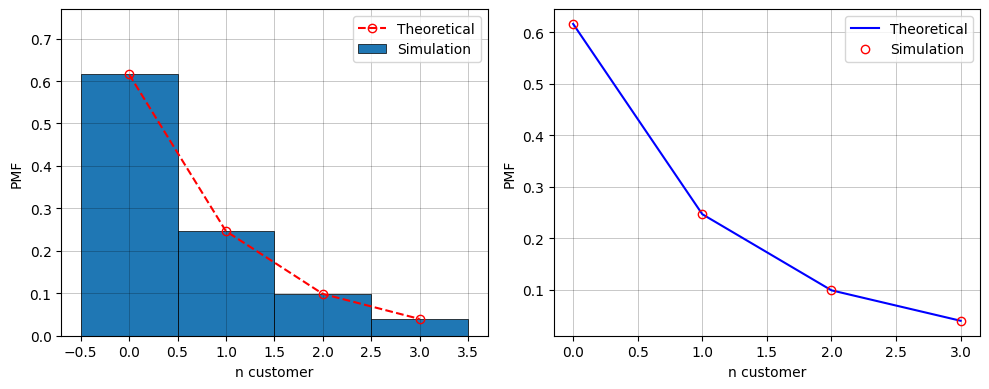


-------PDF of the total time of customers in the system------


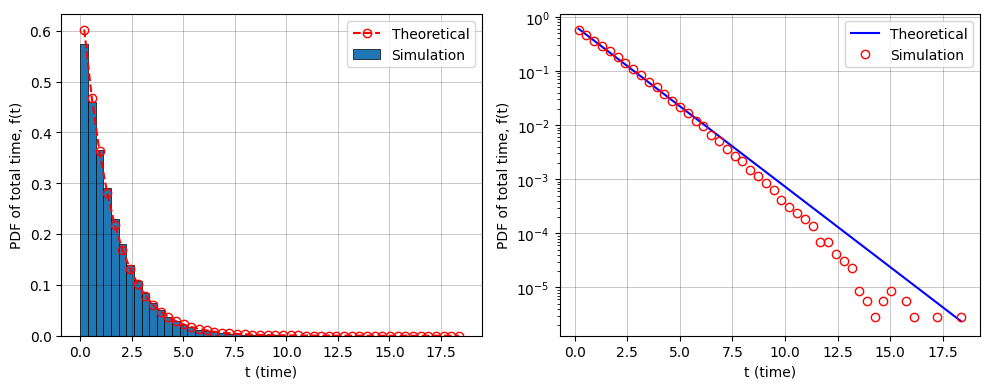

In [8]:
lmbda, mu = 0.4, 1.0
num_customers = 1000000
k = 3
#----theoretical results----
theo_E_N, theo_E_Nq, theo_E_T, theo_E_W, theo_block_prob = \
        theoretical_results(lmbda, mu, k)
theo_PMF = theoretical_PMF(lmbda, mu, k)

print("------Theoretical results------")
print(f"E[N] = {theo_E_N}")
print(f"E[Nq] = {theo_E_Nq}")
print(f"E[T] = {theo_E_T}")
print(f"E[W] = {theo_E_W}")
print(f"Probability of being blocked = {theo_block_prob}")

#------simulation results-----
IAT = np.random.exponential(1/lmbda, num_customers)
ST = np.random.exponential(1/mu, num_customers)
AT = np.cumsum(IAT)
actual_AT, DT, TT, WT, sim_block_prob = \
                main_loop(num_customers, AT, ST, k)

sim_E_N, sim_E_Nq, sim_PMF = track_customers(actual_AT, DT, max_N=k)
sim_E_T = np.mean(TT)
sim_E_W = np.mean(WT)

print("\n------simulation results------")
print(f"E[N] = {sim_E_N}")
print(f"E[Nq] = {sim_E_Nq}")
print(f"E[T] = {sim_E_T}")
print(f"E[W] = {sim_E_W}")
print(f"Probability of being blocked = {sim_block_prob}")


print("\n-------PMF of number of customers in the system------")
plot_PMF(sim_PMF, theo_PMF, semilog=False)
print("\n-------PDF of the total time of customers in the system------")
plot_PDF(TT, theo_E_T, num_bins=50)

In [45]:
def variable_traffic_intensity(start, end, step_size, num_customers=100000, k=5):
  n_points = int( (end - start + 1) / step_size )
  rho = np.linspace(start, end, n_points)
  mu = 1.0

  #-----dict to store theoretical results-----
  theo_results = {
      "E_N": np.zeros(len(rho)),
      "E_Nq": np.zeros(len(rho)),
      "E_T": np.zeros(len(rho)),
      "E_W": np.zeros(len(rho)),
      "block_prob": np.zeros(len(rho)),
  }
  #-----dict to store simulation results----
  sim_results = {
      "E_N": np.zeros(len(rho)),
      "E_Nq": np.zeros(len(rho)),
      "E_T": np.zeros(len(rho)),
      "E_W": np.zeros(len(rho)),
      "block_prob": np.zeros(len(rho)),
  }
  keys = list(theo_results.keys())

  for i in range(len(rho)):
    lmbda = mu * rho[i]
    theo_output = theoretical_results(lmbda, mu, k)
    sim_output = simulation_results(num_customers, k, lmbda, mu)
    for j in range(len(theo_results)):
      key = keys[j]
      sim_results[key][i] = sim_output[j]
      theo_results[key][i] = theo_output[j]

  #------plot-----
  n_rows, n_cols = 3, 2
  labels = ["E[N] (customer)", "E[Nq] (customer)",
            "E[T] (time)", "E[W] (time)", "Blocking probability"]
  figure = plt.figure(figsize=(10, 13), dpi=100, tight_layout=True)
  for i in range(len(keys)):
    key, label = keys[i], labels[i]
    ax = figure.add_subplot(n_rows, n_cols, i+1)
    ax.set_title(f"Number of customers = {num_customers} & Buffer size = {k - 1}")
    ax.set_xlabel("Traffic intensity (Erlang)")
    ax.set_ylabel(label)
    ax.plot(rho, theo_results[key], linestyle="--",
            color="blue", label="Theoretical")
    ax.plot(rho, sim_results[key], linestyle="None", marker="o",
            color="red", markerfacecolor="None", label="Simulation")
    plt.legend()
    plt.grid(color="black", alpha=0.3, linewidth=0.5)

  plt.show()

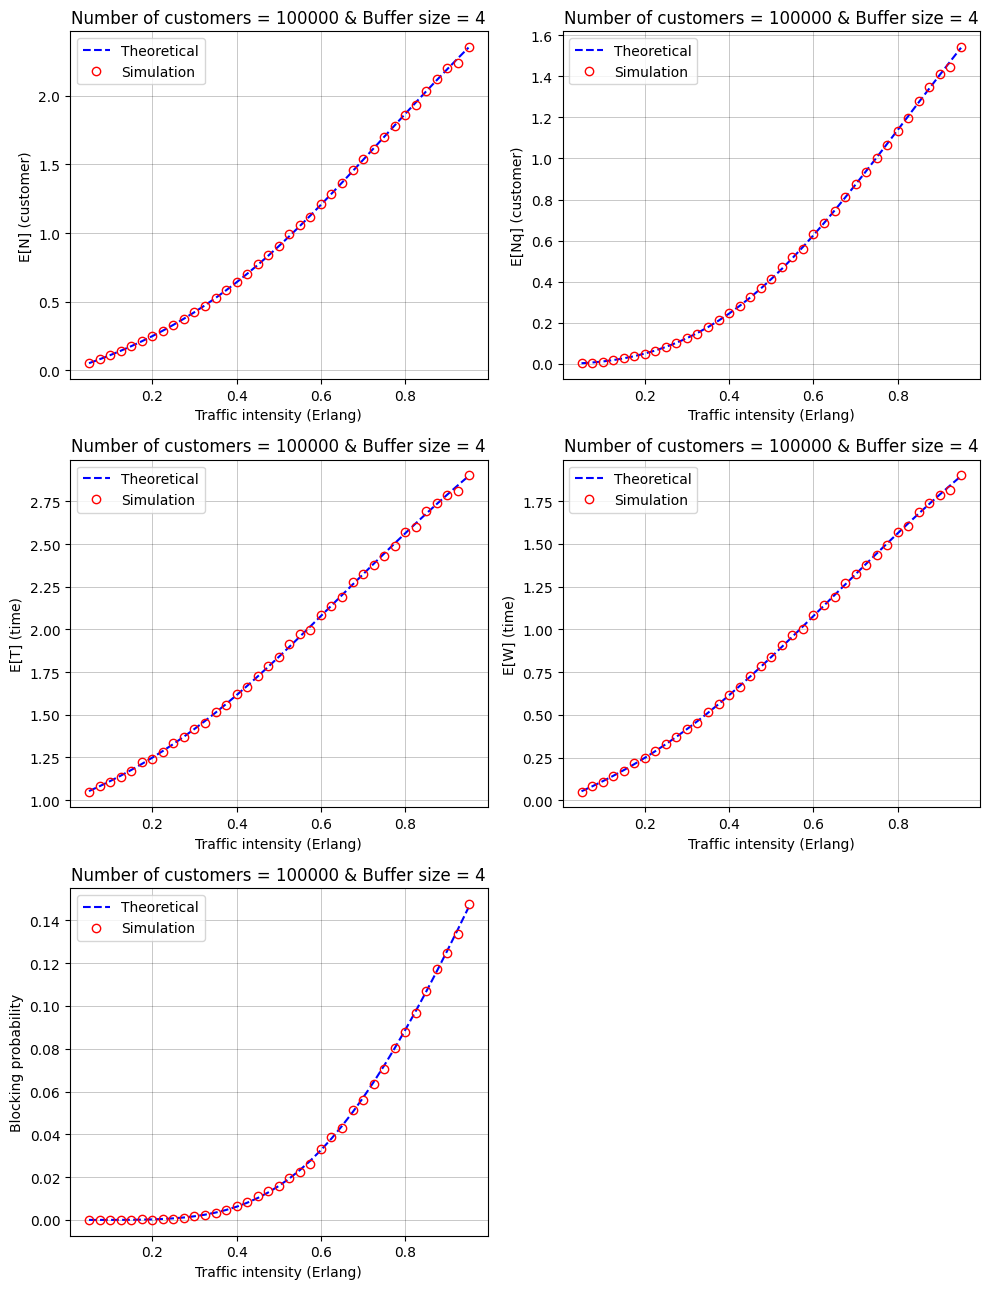

In [41]:
variable_traffic_intensity(0.05, 0.95, 0.05, k=5)

In [49]:
def inf_buffer_theo_results(lmbda, mu):
  rho = lmbda / mu
  E_N = rho / (1 - rho)
  E_Nq = rho**2 / (1 - rho)
  E_T = 1 / (mu - lmbda)
  E_W = E_T - 1/mu
  block_prob = 0
  return E_N, E_Nq, E_T, E_W, block_prob

In [59]:
def variable_buffer_size(num_customers, lmbda, mu, min_size=1, max_size=50):
  buffer_size = np.arange(min_size, max_size +1, 1)
  inf_theo_results = inf_buffer_theo_results(lmbda, mu)
  sim_results = {
      "E_N": np.zeros(len(buffer_size)),
      "E_Nq": np.zeros(len(buffer_size)),
      "E_T": np.zeros(len(buffer_size)),
      "E_W": np.zeros(len(buffer_size)),
      "block_prob": np.zeros(len(buffer_size)),
  }
  keys = list(sim_results.keys())
  for i in range(len(buffer_size)):
    k = buffer_size[i] + 1
    sim_output = simulation_results(num_customers, k, lmbda, mu)
    for j in range(len(keys)):
      key = keys[j]
      sim_results[key][i] = sim_output[j]

  n_rows, n_cols = 3, 2
  labels = ["E[N] (customer)", "E[Nq] (customer)",
            "E[T] (time)", "E[W] (time)", "Blocking probability"]
  figure = plt.figure(figsize=(10, 12), dpi=100, tight_layout=True)
  for i in range(len(labels)):
    key, label = keys[i], labels[i]
    ax = figure.add_subplot(n_rows, n_cols, i+1)
    ax.set_xlabel("Buffer size")
    ax.set_ylabel(label)
    ax.axhline(y=inf_theo_results[i], linestyle="--", color="blue",
            label="Infinite buffer")
    ax.plot(buffer_size, sim_results[key], linestyle="-", marker="o",
            color="red", markerfacecolor="None", label="Simulation (finite buffer)")
    plt.legend()
    plt.grid(color="black", alpha=0.3, linewidth=0.5)

  plt.show()

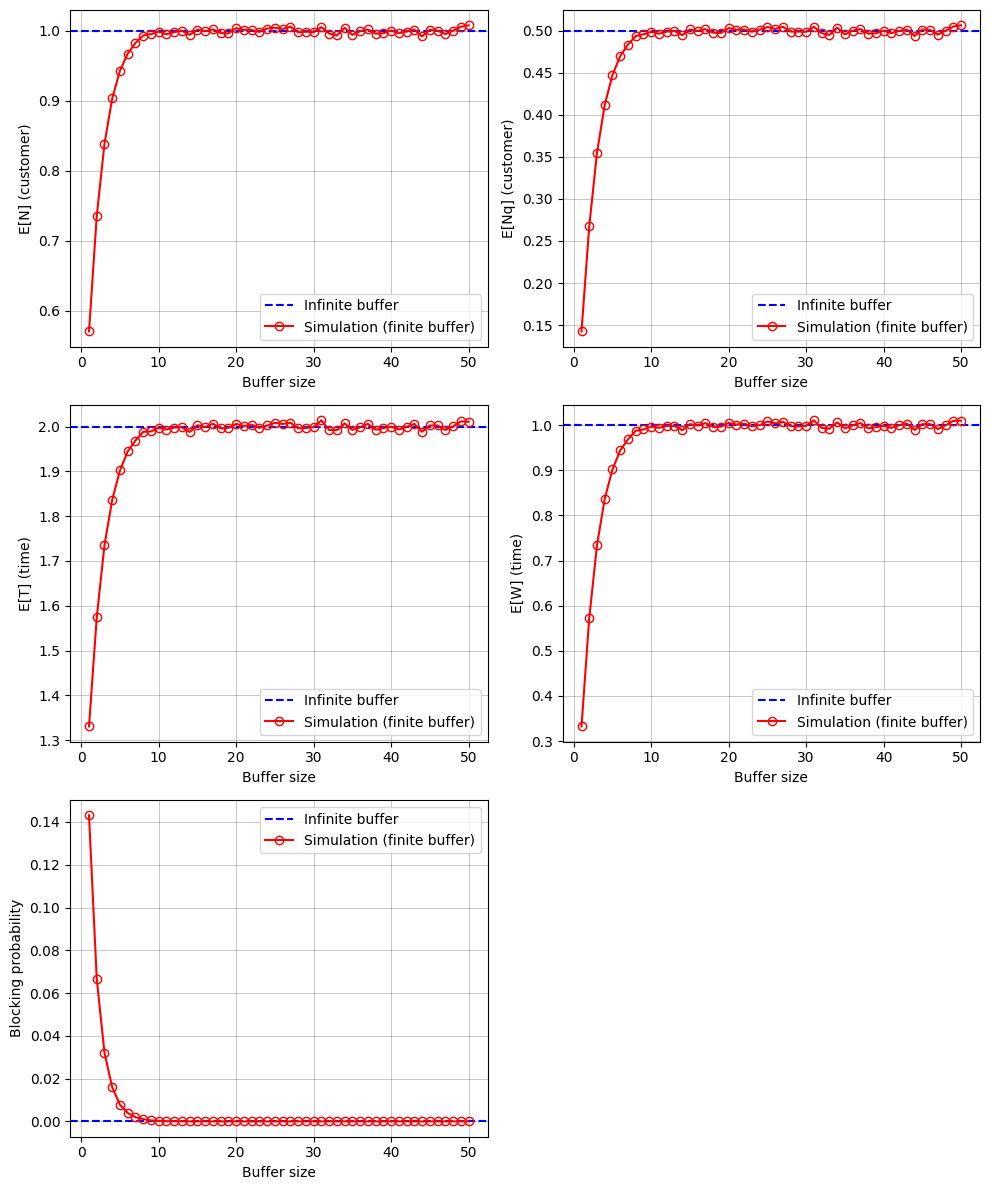

In [60]:
variable_buffer_size(1000000, lmbda=0.5, mu=1)